# Import Libraries

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
from sklearn.preprocessing import QuantileTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.datasets import make_regression
from sklearn.ensemble import GradientBoostingRegressor

# Load Data

In [5]:
df_train = pd.read_csv("/content/train.csv")

In [6]:
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [7]:
df_test = pd.read_csv("/content/test.csv")

# Data Exploration

# Count missing values in each column

In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [9]:
missing = df_train.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace = True)
missing

Electrical         1
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
BsmtExposure      38
BsmtFinType2      38
GarageCond        81
GarageQual        81
GarageFinish      81
GarageType        81
GarageYrBlt       81
LotFrontage      259
FireplaceQu      690
Fence           1179
Alley           1369
MiscFeature     1406
PoolQC          1453
dtype: int64

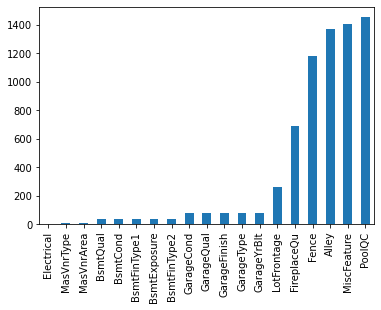

In [10]:
missing.plot.bar()

# Feature Engineering

Check fields with large missing data from the description:


*   PoolQC means Pool Quality and NA means No Pool (it is not a missing value and it will impact the peroformance). You will notice that values are (Ex	Excellent, Gd	Good, TA	Average/Typical, Fa	Fair, NA	No Pool). The order here make sense
*   Find and replace is the best approach in this case





In [11]:
# create a dictionary use table names and values
cleanup_nums = {"PoolQC":     {"Ex": 4, "Gd": 3, "TA":2, "Fa":1, "NA":0}}



*   MiscFeature includes: Elev	Elevator, Gar2	2nd Garage (if not 
described in garage section), Othr	Other, Shed	Shed (over 100 SF), TenC	Tennis Court, NA	None 
*    Replacing NA with the most frequent term does not make sense here
*    We can use None as a separate category 
*    One hot encoding will be a good choice here 



In [12]:
df_train["MiscFeature"] = df_train["MiscFeature"].astype('category')
df_train["MiscFeature"] = df_train["MiscFeature"].cat.add_categories(['MISSING'])
df_train["MiscFeature"] = df_train["MiscFeature"].fillna('MISSING')

df_test["MiscFeature"] = df_test["MiscFeature"].astype('category')
df_test["MiscFeature"] = df_test["MiscFeature"].cat.add_categories(['MISSING'])
df_test["MiscFeature"] = df_test["MiscFeature"].fillna('MISSING')

Alley: Type of alley access to property. The field values are defined as:
*   Grvl	Gravel
*   Pave	Paved
*   NA 	No alley access

Similar to MiscFeature, we can use None as a separate category and One hot encoding will be a good choice here

In [13]:
df_train["Alley"] = df_train["Alley"].astype('category')
df_train["Alley"] = df_train["Alley"].cat.add_categories(['MISSING'])
df_train["Alley"] = df_train["Alley"].fillna('MISSING')

df_test["Alley"] = df_test["Alley"].astype('category')
df_test["Alley"] = df_test["Alley"].cat.add_categories(['MISSING'])
df_test["Alley"] = df_test["Alley"].fillna('MISSING')

Fence: Fence quality.  The field values are defined as 
*   GdPrv	Good Privacy
*   MnPrv	Minimum Privacy
*   GdWo	Good Wood
*   MnWw	Minimum Wood/Wire
*   NA	No Fence

We will use the above technique      

In [14]:
df_train["Fence"] = df_train["Fence"].astype('category')
df_train["Fence"] = df_train["Fence"].cat.add_categories(['MISSING'])
df_train["Fence"] = df_train["Fence"].fillna('MISSING')

df_test["Fence"] = df_test["Fence"].astype('category')
df_test["Fence"] = df_test["Fence"].cat.add_categories(['MISSING'])
df_test["Fence"] = df_test["Fence"].fillna('MISSING')

FireplaceQu: Fireplace quality

       Ex	Excellent - Exceptional Masonry Fireplace
       Gd	Good - Masonry Fireplace in main level
       TA	Average - Prefabricated Fireplace in main living area or Masonry Fireplace in basement
       Fa	Fair - Prefabricated Fireplace in basement
       Po	Poor - Ben Franklin Stove
       NA	No Fireplace


We will use find and replace


In [15]:
cleanup_nums['FireplaceQu'] = {"Ex": 5, "Gd": 4, "TA":3, "Fa":2, "Po":1, "NA":0}

The last item is the lot frontage (واجهة الشارع).Linear feet of street connected to property.


We may use the median in this case


In [16]:
df_train['LotFrontage'].fillna(value=df_train['LotFrontage'].median(), inplace=True)
df_test['LotFrontage'].fillna(value=df_train['LotFrontage'].median(), inplace=True)

In [17]:
# Similarly, we fix GarageCond using find and replace
cleanup_nums['GarageCond']= {"Ex": 5, "Gd": 4, "TA":3, "Fa":2, "Po":1, "NA":0}
cleanup_nums['GarageQual']= {"Ex": 5, "Gd": 4, "TA":3, "Fa":2, "Po":1, "NA":0}
cleanup_nums['GarageFinish']= {"Fin": 3, "RFn": 2, "Unf":1, "NA":0}
cleanup_nums['BsmtQual']= {"Ex": 5, "Gd": 4, "TA":3, "Fa":2, "Po":1, "NA":0}
cleanup_nums['BsmtCond']= {"Ex": 5, "Gd": 4, "TA":3, "Fa":2, "Po":1, "NA":0}
cleanup_nums['BsmtExposure']= {"Gd": 4, "Av": 3, "Mn":2, "No":1, "NA":0}
cleanup_nums['BsmtFinType1']= {"GLQ": 6, "ALQ": 5, "BLQ":4, "Rec":3, "LwQ":2, "Unf":1, "NA":0}
cleanup_nums['BsmtFinType2']= {"GLQ": 6, "ALQ": 5, "BLQ":4, "Rec":3, "LwQ":2, "Unf":1, "NA":0}

# for GarageType, NA means no garage
df_train["GarageType"] = df_train["GarageType"].astype('category')
df_train["GarageType"] = df_train["GarageType"].cat.add_categories(['MISSING'])
df_train["GarageType"] = df_train["GarageType"].fillna('MISSING')

df_test["GarageType"] = df_test["GarageType"].astype('category')
df_test["GarageType"] = df_test["GarageType"].cat.add_categories(['MISSING'])
df_test["GarageType"] = df_test["GarageType"].fillna('MISSING')

# for MasVnrType  Masonry veneer type, None means no Maonry veneer
df_train["MasVnrType"] = df_train["MasVnrType"].astype('category')
df_train["MasVnrType"] = df_train["MasVnrType"].cat.add_categories(['MISSING'])
df_train["MasVnrType"] = df_train["MasVnrType"].fillna('MISSING')

df_test["MasVnrType"] = df_test["MasVnrType"].astype('category')
df_test["MasVnrType"] = df_test["MasVnrType"].cat.add_categories(['MISSING'])
df_test["MasVnrType"] = df_test["MasVnrType"].fillna('MISSING')

# for Area, can can use the median
df_train['MasVnrArea'].fillna(value=df_train['MasVnrArea'].median(), inplace=True)
df_test['MasVnrArea'].fillna(value=df_train['MasVnrArea'].median(), inplace=True)

# for Electrical, we can use the most frequent label (gets index 0).
df_train["Electrical"] = df_train["MasVnrType"].astype('category')
df_train['Electrical'].fillna(value=df_train['Electrical'].value_counts().index[0], inplace=True)
df_test['Electrical'].fillna(value=df_train['Electrical'].value_counts().index[0], inplace=True)

In [18]:
# we completed these with large number of missing values, let's replace
df_train = df_train.replace(cleanup_nums)
#fill NAN values as well  
df_train['PoolQC'].fillna(value= 0, inplace=True)
df_train['FireplaceQu'].fillna(value= 0, inplace=True)
df_train['GarageCond'].fillna(value= 0, inplace=True)
df_train['GarageQual'].fillna(value= 0, inplace=True)
df_train['GarageFinish'].fillna(value= 0, inplace=True)
df_train['BsmtQual'].fillna(value= 0, inplace=True)
df_train['BsmtCond'].fillna(value= 0, inplace=True)
df_train['BsmtExposure'].fillna(value= 0, inplace=True)
df_train['BsmtFinType1'].fillna(value= 0, inplace=True)
df_train['BsmtFinType2'].fillna(value= 0, inplace=True)

df_test = df_test.replace(cleanup_nums)
df_test['PoolQC'].fillna(value= 0, inplace=True)
df_test['FireplaceQu'].fillna(value= 0, inplace=True)
df_test['GarageCond'].fillna(value= 0, inplace=True)
df_test['GarageQual'].fillna(value= 0, inplace=True)
df_test['GarageFinish'].fillna(value= 0, inplace=True)
df_test['BsmtQual'].fillna(value= 0, inplace=True)
df_test['BsmtCond'].fillna(value= 0, inplace=True)
df_test['BsmtExposure'].fillna(value= 0, inplace=True)
df_test['BsmtFinType1'].fillna(value= 0, inplace=True)
df_test['BsmtFinType2'].fillna(value= 0, inplace=True)
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,MISSING,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,4.0,3.0,1.0,6.0,706,1.0,0,150,856,GasA,...,Y,BrkFace,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,0.0,Attchd,2003.0,2.0,2,548,3.0,3.0,Y,0,61,0,0,0,0,0.0,MISSING,MISSING,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,MISSING,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,4.0,3.0,4.0,5.0,978,1.0,0,284,1262,GasA,...,Y,None,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,3.0,Attchd,1976.0,2.0,2,460,3.0,3.0,Y,298,0,0,0,0,0,0.0,MISSING,MISSING,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,MISSING,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,4.0,3.0,2.0,6.0,486,1.0,0,434,920,GasA,...,Y,BrkFace,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,3.0,Attchd,2001.0,2.0,2,608,3.0,3.0,Y,0,42,0,0,0,0,0.0,MISSING,MISSING,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,MISSING,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,3.0,4.0,1.0,5.0,216,1.0,0,540,756,GasA,...,Y,None,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,4.0,Detchd,1998.0,1.0,3,642,3.0,3.0,Y,0,35,272,0,0,0,0.0,MISSING,MISSING,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,MISSING,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,4.0,3.0,3.0,6.0,655,1.0,0,490,1145,GasA,...,Y,BrkFace,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,3.0,Attchd,2000.0,2.0,3,836,3.0,3.0,Y,192,84,0,0,0,0,0.0,MISSING,MISSING,0,12,2008,WD,Normal,250000


Check missing values one more time

In [19]:
missing = df_train.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace = True)
missing

GarageYrBlt    81
dtype: int64

For the GarageYrBlt I will convert it to categorical to show how old the garage 

In [20]:
most_recent = df_train['GarageYrBlt'].max()
oldest = df_train['GarageYrBlt'].min()
period = int((most_recent - oldest)/5)
bins = [np.NINF, period, 2*period, 3*period, 4*period, 5*period, np.inf]
df_train['GarageYrBlt']= np.digitize(most_recent- df_train['GarageYrBlt'],bins,right=True)
df_test['GarageYrBlt']= np.digitize(most_recent- df_test['GarageYrBlt'],bins,right=True)
df_train['GarageYrBlt'].min()

1

In [21]:
df_train['GarageYrBlt'].fillna(value= 7, inplace=True)
df_test['GarageYrBlt'].fillna(value= 7, inplace=True)


We can do similar analysis to transform other features such as HeatingQC, ExterQual, etc. (try it yourself)

# Missing data test



In [22]:
missing = df_test.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace = True)
missing

Exterior1st     1
Exterior2nd     1
BsmtFinSF1      1
BsmtFinSF2      1
BsmtUnfSF       1
TotalBsmtSF     1
KitchenQual     1
GarageCars      1
GarageArea      1
SaleType        1
Utilities       2
BsmtFullBath    2
BsmtHalfBath    2
Functional      2
MSZoning        4
dtype: int64

In [23]:
df_test['Exterior1st'].fillna(value=df_train['Exterior1st'].value_counts().index[0], inplace=True)
df_test['Exterior2nd'].fillna(value=df_train['Exterior2nd'].value_counts().index[0], inplace=True)
df_test['BsmtFinSF1'].fillna(value=df_train['BsmtFinSF1'].median(), inplace=True)
df_test['BsmtFinSF2'].fillna(value=df_train['BsmtFinSF2'].median(), inplace=True)
df_test['BsmtUnfSF'].fillna(value=df_train['BsmtUnfSF'].median(), inplace=True)
df_test['TotalBsmtSF'].fillna(value=df_train['TotalBsmtSF'].median(), inplace=True)
df_test['KitchenQual'].fillna(value=df_train['KitchenQual'].value_counts().index[0], inplace=True)
df_test['GarageCars'].fillna(value=df_train['GarageCars'].median(), inplace=True)
df_test['GarageArea'].fillna(value=df_train['GarageArea'].median(), inplace=True)
df_test['SaleType'].fillna(value=df_train['SaleType'].value_counts().index[0], inplace=True)
df_test['Utilities'].fillna(value=df_train['Utilities'].value_counts().index[0], inplace=True)
df_test['BsmtFullBath'].fillna(value=df_train['BsmtFullBath'].median(), inplace=True)
df_test['BsmtHalfBath'].fillna(value=df_train['BsmtHalfBath'].median(), inplace=True)
df_test['Functional'].fillna(value=df_train['Functional'].value_counts().index[0], inplace=True)
df_test['MSZoning'].fillna(value=df_train['MSZoning'].value_counts().index[0], inplace=True)

In [24]:
df_train['KitchenQual'].value_counts()

TA    735
Gd    586
Ex    100
Fa     39
Name: KitchenQual, dtype: int64

In [25]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             1460 non-null   int64   
 1   MSSubClass     1460 non-null   int64   
 2   MSZoning       1460 non-null   object  
 3   LotFrontage    1460 non-null   float64 
 4   LotArea        1460 non-null   int64   
 5   Street         1460 non-null   object  
 6   Alley          1460 non-null   category
 7   LotShape       1460 non-null   object  
 8   LandContour    1460 non-null   object  
 9   Utilities      1460 non-null   object  
 10  LotConfig      1460 non-null   object  
 11  LandSlope      1460 non-null   object  
 12  Neighborhood   1460 non-null   object  
 13  Condition1     1460 non-null   object  
 14  Condition2     1460 non-null   object  
 15  BldgType       1460 non-null   object  
 16  HouseStyle     1460 non-null   object  
 17  OverallQual    1460 non-null   in

In [26]:
# get a list of qulitative features
qualitative = df_train.select_dtypes(exclude= ['int64', 'float64'])
qualitative

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,GarageType,PavedDrive,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,MISSING,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,GasA,Ex,Y,BrkFace,Gd,Typ,Attchd,Y,MISSING,MISSING,WD,Normal
1,RL,Pave,MISSING,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,Gable,CompShg,MetalSd,MetalSd,None,TA,TA,CBlock,GasA,Ex,Y,None,TA,Typ,Attchd,Y,MISSING,MISSING,WD,Normal
2,RL,Pave,MISSING,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,GasA,Ex,Y,BrkFace,Gd,Typ,Attchd,Y,MISSING,MISSING,WD,Normal
3,RL,Pave,MISSING,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,Gable,CompShg,Wd Sdng,Wd Shng,None,TA,TA,BrkTil,GasA,Gd,Y,None,Gd,Typ,Detchd,Y,MISSING,MISSING,WD,Abnorml
4,RL,Pave,MISSING,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,GasA,Ex,Y,BrkFace,Gd,Typ,Attchd,Y,MISSING,MISSING,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,RL,Pave,MISSING,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,None,TA,TA,PConc,GasA,Ex,Y,None,TA,Typ,Attchd,Y,MISSING,MISSING,WD,Normal
1456,RL,Pave,MISSING,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,Gable,CompShg,Plywood,Plywood,Stone,TA,TA,CBlock,GasA,TA,Y,Stone,TA,Min1,Attchd,Y,MnPrv,MISSING,WD,Normal
1457,RL,Pave,MISSING,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,Gable,CompShg,CemntBd,CmentBd,None,Ex,Gd,Stone,GasA,Ex,Y,None,Gd,Typ,Attchd,Y,GdPrv,Shed,WD,Normal
1458,RL,Pave,MISSING,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,Hip,CompShg,MetalSd,MetalSd,None,TA,TA,CBlock,GasA,Gd,Y,None,Gd,Typ,Attchd,Y,MISSING,MISSING,WD,Normal


# Encoding

In [27]:
y_train=df_train['SalePrice']
x_train = df_train.loc[:, df_train.columns != 'SalePrice']
ohe = OneHotEncoder(handle_unknown='ignore')
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', ohe, qualitative.columns)],
        remainder="passthrough")
X_train_encoded = preprocessor.fit_transform(x_train)
X_test_encoded = preprocessor.transform(df_test)

# First Model

In [28]:
lin_reg = LinearRegression()
lin_reg.fit(X_train_encoded, y_train)
lin_reg.intercept_, lin_reg.coef_
# notice the magnitude of the coefficients

(-148929.85751216926,
 array([-2.30802187e+04,  1.33502905e+04,  2.55558495e+03,  4.80236409e+03,
         2.37197914e+03, -1.74227275e+04,  1.74227275e+04, -4.10855218e+02,
         8.75912223e+01,  3.23263993e+02, -3.16153617e+03,  3.33307535e+03,
         1.51754585e+03, -1.68908503e+03, -1.78748553e+03,  7.06019938e+03,
        -9.91699739e+03,  4.64428353e+03,  1.67875840e+04, -1.67875840e+04,
         2.77385355e+03,  1.25566982e+04, -3.08841036e+03, -1.44473601e+04,
         2.20521867e+03,  8.40749727e+03,  1.51673006e+04, -2.35747978e+04,
         3.21735715e+03,  1.04398297e+04,  7.37598854e+03, -7.43626414e+02,
        -1.15256854e+04, -1.04227450e+04,  1.42838239e+04, -1.60186564e+04,
        -1.03302977e+04, -7.76663295e+03, -1.20595377e+03, -1.70536924e+04,
        -1.26855810e+04,  1.10170782e+04, -1.58747281e+04,  2.54565046e+04,
         2.18434698e+04, -8.15747008e+03, -7.60969121e+03, -5.58035948e+03,
        -1.89803964e+03, -3.27062732e+03,  4.05499826e+04, -5.9284

In [29]:
y_predicted = lin_reg.predict(X_train_encoded)
mse = mean_squared_error(y_train, y_predicted)
r2 = r2_score(y_train, y_predicted)
print(mse)
print(r2)

454907294.0665596
0.9278702166863003


In [30]:
y_predicted

array([207932.52483643, 206500.63140337, 207180.28049193, ...,
       270405.31369812, 137886.92656824, 150325.03369517])

In [31]:
y_predicted = lin_reg.predict(X_test_encoded)
df_test['SalePrice']=y_predicted
header = ["Id", "SalePrice"]
df_test.to_csv('output.csv', columns = header, index=False)

# Third Model: Gradient boosting regression


In [ ]:
#Discarded
'''
X_train_encoded, y_train = make_regression(random_state=0)
X_trainR, X_testR, y_trainR, y_testR = train_test_split(X_train_encoded, y_train, test_size=0.2, random_state=0)
reg = GradientBoostingRegressor(random_state=0)
reg.fit(X_trainR, y_trainR)
y_pred = reg.predict(X_testR)
print(r2_score(y_testR, y_pred))
'''

NameError: ignored

A last trial is using gridsearch to see whethere this model can work or not.

In [ ]:
parameters = {'learning_rate': [0.01,0.02,0.03,0.04],
              'subsample'    : [0.9, 0.5, 0.2, 0.1],
              'n_estimators' : [1000, 1100, 1200, 1500],
              'max_depth'    : [4,6,8,10]
                 }
rf = GradientBoostingRegressor()
grid_search = GridSearchCV(estimator=rf, param_grid = parameters)
grid_search.fit(X_train_encoded, y_train)

KeyboardInterrupt: ignored

In [ ]:
print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",grid_search.best_estimator_)
print("\n The best score across ALL searched params:\n",grid_search.best_score_)
print("\n The best parameters across ALL searched params:\n",grid_search.best_params_)

 Results from Grid Search 


AttributeError: ignored

In [33]:
reg = GradientBoostingRegressor(n_estimators=1500, learning_rate=0.03, max_depth=6, subsample=0.5, max_features=12, random_state=5)
reg.fit(X_train_encoded, y_train)
y_pred = reg.predict(X_train_encoded)
print(r2_score(y_train,y_pred))

0.9994236998335893


In [34]:
y_predicted_Final = reg.predict(X_test_encoded)
df_test['SalePrice']=y_predicted_Final
header = ["Id", "SalePrice"]
df_test.to_csv('output.csv', columns = header, index=False)